
# NILM Unsupervised Learning: Daily Usage Profiling


In [2]:

from __future__ import annotations

import math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

DATASET_PATH = Path("./data/household_power_consumption.txt")


## 1. Problem Definition (Unsupervised)

**Goal:** Cluster **days** by their electricity consumption profiles to reveal typical usage behaviors 
(e.g., low vs. high usage days, weekday/weekend effects, seasonal shifts, appliance contributions).

There are two pipelines:

1. **Baseline**: Standardize daily features → **K-Means**.  
2. **With Dimensionality Reduction**: Standardize → **PCA (retain 95% variance)** → **K-Means**.


## 2. Load the File & Convert Dtypes

In [3]:
raw = pd.read_csv(
    DATASET_PATH,
    sep=";",
    na_values=["?", ""],
    low_memory=False
)

raw["datetime"] = pd.to_datetime(raw["Date"] + " " + raw["Time"], dayfirst=True, errors="coerce")
raw = raw.drop(columns=["Date", "Time"])

for c in raw.columns:
    if c != "datetime":
        raw[c] = pd.to_numeric(raw[c], errors="coerce")

raw = raw.dropna(subset=["datetime"]).sort_values("datetime").reset_index(drop=True)
raw.info()
raw.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48424 entries, 0 to 48423
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Global_active_power    48419 non-null  float64       
 1   Global_reactive_power  48419 non-null  float64       
 2   Voltage                48419 non-null  float64       
 3   Global_intensity       48419 non-null  float64       
 4   Sub_metering_1         48419 non-null  float64       
 5   Sub_metering_2         48419 non-null  float64       
 6   Sub_metering_3         48419 non-null  float64       
 7   datetime               48424 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7)
memory usage: 3.0 MB


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,datetime
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00



## 3. Preprocessing
Steps:
1. **Time alignment** to exact 1-minute frequency.
2. **Interpolation** (time-based) for short gaps (dataset has ~1.25% missing).
3. **Derived feature**: *Other active energy* per minute (the portion not accounted for by sub-meterings 1–3).
4. **Daily aggregation** to produce features per day (sums, means, std, max, ratios).


In [ ]:
data = raw.set_index("datetime")
full_idx = pd.date_range(start=data.index.min(), end=data.index.max(), freq="1min")
data = data.reindex(full_idx)

data = data.interpolate(method="time", limit_direction="both")

data["Other_active_energy_Wh"] = (
    data["Global_active_power"] * 1000.0 / 60.0
    - (data["Sub_metering_1"] + data["Sub_metering_2"] + data["Sub_metering_3"])  # sub-meters are in Wh/min
).clip(lower=0)

daily = pd.DataFrame({
    "active_energy_Wh_sum": (data["Global_active_power"] * 1000.0 / 60.0).resample("1D").sum(),
    "reactive_power_mean": data["Global_reactive_power"].resample("1D").mean(),
    "voltage_mean": data["Voltage"].resample("1D").mean(),
    "voltage_std": data["Voltage"].resample("1D").std(),
    "intensity_mean": data["Global_intensity"].resample("1D").mean(),
    "intensity_max": data["Global_intensity"].resample("1D").max(),
    "sub1_Wh_sum": data["Sub_metering_1"].resample("1D").sum(),
    "sub2_Wh_sum": data["Sub_metering_2"].resample("1D").sum(),
    "sub3_Wh_sum": data["Sub_metering_3"].resample("1D").sum(),
    "other_Wh_sum": data["Other_active_energy_Wh"].resample("1D").sum(),
    "measurements": data["Voltage"].resample("1D").count(),
})

total_sub = daily[["sub1_Wh_sum", "sub2_Wh_sum", "sub3_Wh_sum", "other_Wh_sum"]].sum(axis=1)
total_sub = total_sub.replace(0, np.nan)
daily["sub1_ratio"] = daily["sub1_Wh_sum"] / total_sub
daily["sub2_ratio"] = daily["sub2_Wh_sum"] / total_sub
daily["sub3_ratio"] = daily["sub3_Wh_sum"] / total_sub
daily["other_ratio"] = daily["other_Wh_sum"] / total_sub

daily = daily.dropna()
daily.head()


,active_energy_Wh_sum,reactive_power_mean,voltage_mean,voltage_std,intensity_mean,intensity_max,sub1_Wh_sum,sub2_Wh_sum,sub3_Wh_sum,other_Wh_sum,measurements,sub1_ratio,sub2_ratio,sub3_ratio,other_ratio
2006-12-16,20152.933333,0.088187,236.243763,2.922896,13.082828,33.2,0.0,546.0,4926.0,14680.933333,396,0.000000,0.027093,0.244431,0.728476
2006-12-17,56507.666667,0.156949,240.087028,4.051467,9.999028,30.0,2033.0,4187.0,13341.0,36946.666667,1440,0.035977,0.074096,0.236092,0.653835
2006-12-18,36730.433333,0.112356,241.231694,3.719576,6.421667,27.0,1063.0,2621.0,14018.0,19028.433333,1440,0.028941,0.071358,0.381645,0.518056
2006-12-19,27769.900000,0.104821,241.999313,3.069492,4.926389,33.6,839.0,7602.0,6197.0,13131.900000,1440,0.030213,0.273750,0.223155,0.472883
2006-12-20,37095.800000,0.111804,242.308062,3.345704,6.467361,25.2,0.0,2648.0,14063.0,20384.800000,1440,0.000000,0.071383,0.379100,0.549518



## 4. Visual Exploration

We plot:
- A sample time window of **Global Active Power**.
- Histograms for key daily features.
- A correlation matrix of daily features.


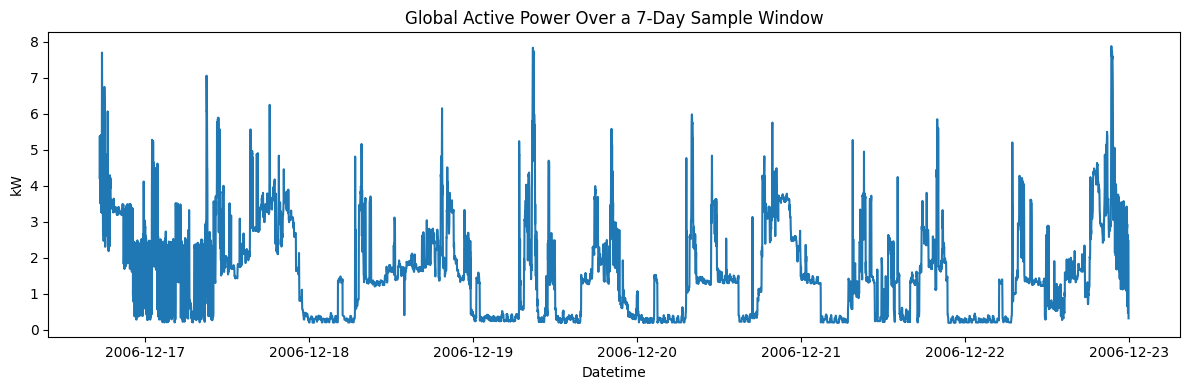

In [ ]:
start_date = daily.index.min()
end_date = start_date + pd.Timedelta(days=7)
mask = (data.index >= start_date) & (data.index < end_date)

plt.figure(figsize=(12, 4))
plt.plot(data.index[mask], data.loc[mask, "Global_active_power"])
plt.title("Global Active Power Over a 7-Day Sample Window")
plt.xlabel("Datetime")
plt.ylabel("kW")
plt.tight_layout()
plt.show()


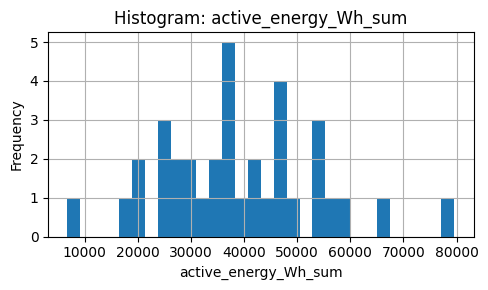

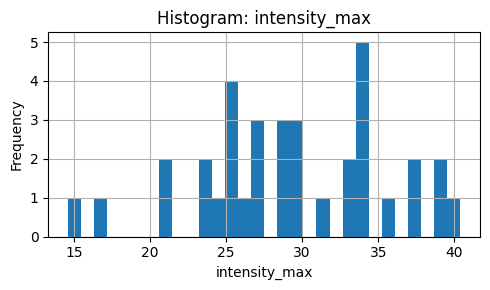

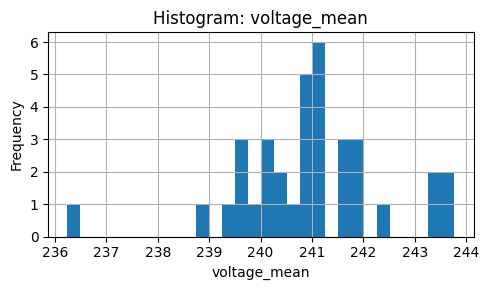

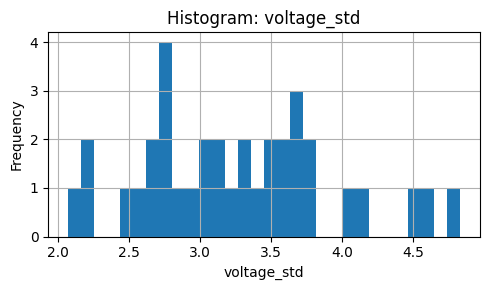

In [ ]:
features_to_plot = ["active_energy_Wh_sum", "intensity_max", "voltage_mean", "voltage_std"]
for col in features_to_plot:
    plt.figure(figsize=(5, 3))
    daily[col].hist(bins=30)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


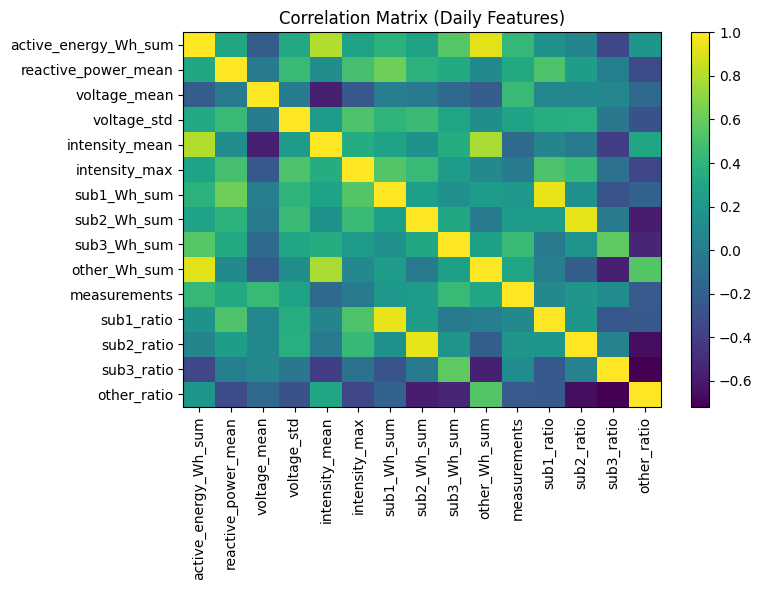

In [7]:
corr = daily.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
plt.imshow(corr.values, aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Matrix (Daily Features)")
plt.colorbar()
plt.tight_layout()
plt.show()


## 5. Baseline Model: K-Means (No Dimensionality Reduction)

The number of cluster k is selected based on various indices


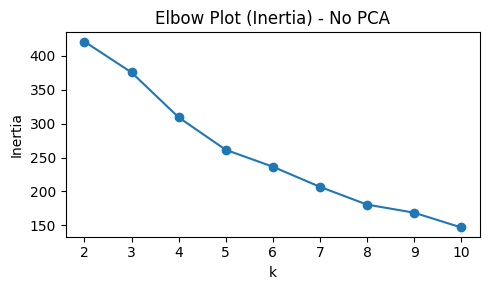

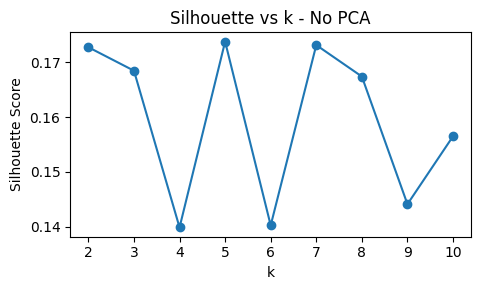

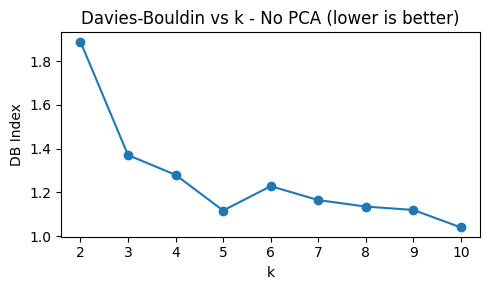

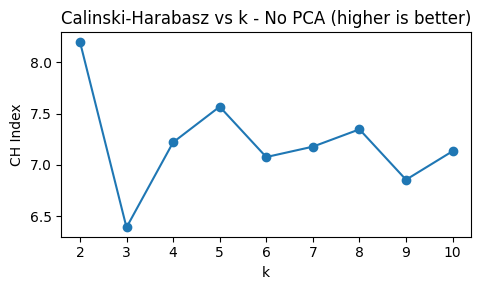

In [13]:
feature_cols = [
    "active_energy_Wh_sum", "reactive_power_mean", "voltage_mean", "voltage_std",
    "intensity_mean", "intensity_max",
    "sub1_Wh_sum", "sub2_Wh_sum", "sub3_Wh_sum", "other_Wh_sum",
    "sub1_ratio", "sub2_ratio", "sub3_ratio", "other_ratio",
    "measurements",
]
X = daily[feature_cols].values
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

ks = list(range(2, 11))
inertias = []
sil_scores = []
db_scores = []
ch_scores = []

for k in ks:
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels = km.fit_predict(Xs)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(Xs, labels))
    db_scores.append(davies_bouldin_score(Xs, labels))
    ch_scores.append(calinski_harabasz_score(Xs, labels))

plt.figure(figsize=(5,3))
plt.plot(ks, inertias, marker="o")
plt.title("Elbow Plot (Inertia) - No PCA")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(ks, sil_scores, marker="o")
plt.title("Silhouette vs k - No PCA")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(ks, db_scores, marker="o")
plt.title("Davies-Bouldin vs k - No PCA (lower is better)")
plt.xlabel("k")
plt.ylabel("DB Index")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(ks, ch_scores, marker="o")
plt.title("Calinski-Harabasz vs k - No PCA (higher is better)")
plt.xlabel("k")
plt.ylabel("CH Index")
plt.tight_layout()
plt.show()


In [15]:
best_k_no_pca = 5
km_no_pca = KMeans(n_clusters=best_k_no_pca, n_init="auto", random_state=42)
labels_no_pca = km_no_pca.fit_predict(Xs)

daily_no_pca = daily.copy()
daily_no_pca["cluster"] = labels_no_pca

summary_no_pca = daily_no_pca.groupby("cluster").agg(
    days=("cluster", "size"),
    energy_Wh=("active_energy_Wh_sum", "mean"),
    intensity_max=("intensity_max", "mean"),
    voltage_mean=("voltage_mean", "mean"),
    sub1_ratio=("sub1_ratio", "mean"),
    sub2_ratio=("sub2_ratio", "mean"),
    sub3_ratio=("sub3_ratio", "mean"),
    other_ratio=("other_ratio", "mean"),
).sort_index()

summary_no_pca.round(2)

,days,energy_Wh,intensity_max,voltage_mean,sub1_ratio,sub2_ratio,sub3_ratio,other_ratio
cluster,,,,,,,,
0,9,56111.78,29.60,240.37,0.03,0.06,0.20,0.71
1,11,27135.87,23.85,241.46,0.02,0.02,0.30,0.66
2,1,20152.93,33.20,236.24,0.00,0.03,0.24,0.73
3,12,36842.33,32.70,241.26,0.05,0.12,0.32,0.51
4,2,49416.12,34.40,241.34,0.15,0.05,0.17,0.63


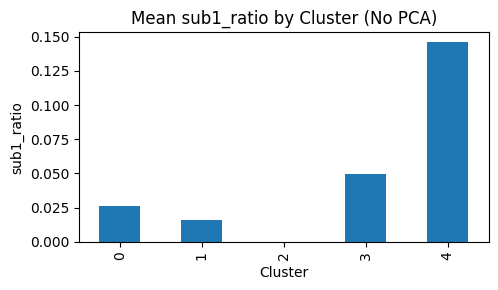

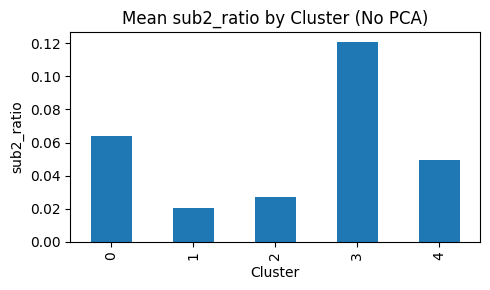

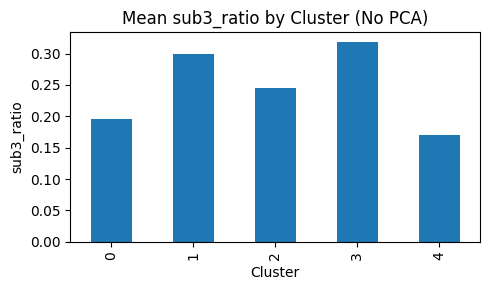

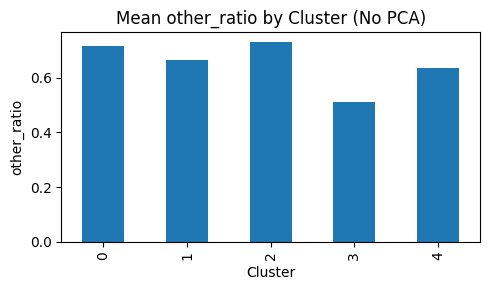

In [ ]:
ratio_cols = ["sub1_ratio", "sub2_ratio", "sub3_ratio", "other_ratio"]
means = daily_no_pca.groupby("cluster")[ratio_cols].mean()

for col in ratio_cols:
    plt.figure(figsize=(5,3))
    means[col].plot(kind="bar")
    plt.title(f"Mean {col} by Cluster (No PCA)")
    plt.xlabel("Cluster")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()



## 6. Model with Dimensionality Reduction: PCA + K-Means

We keep enough components to explain **95%** of the variance, then cluster in the reduced space.


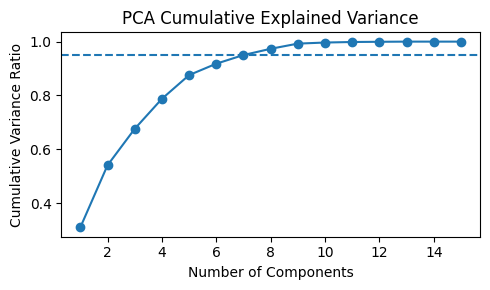

Original features: 15
PCA components kept: 7
Explained variance per component: [0.31005873 0.23068616 0.13531601 0.11148802 0.08813534 0.04234795
 0.03211958]
Cumulative variance: [0.31005873 0.54074488 0.6760609  0.78754892 0.87568426 0.9180322
 0.95015179 0.97335627 0.9925931  0.99661246 0.99859733 0.9993974
 1.         1.         1.        ]


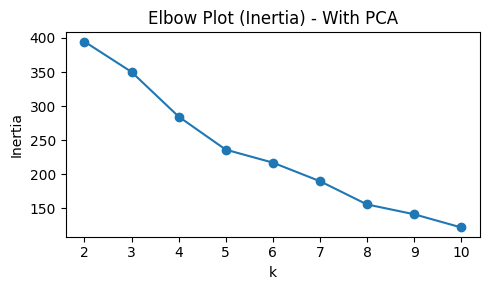

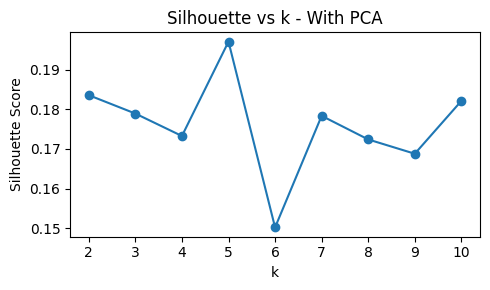

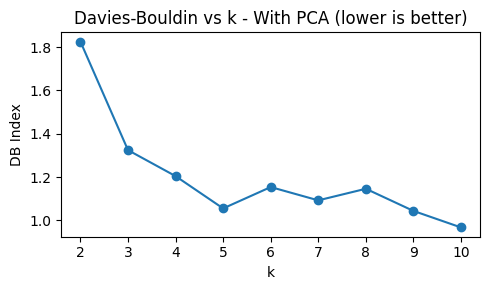

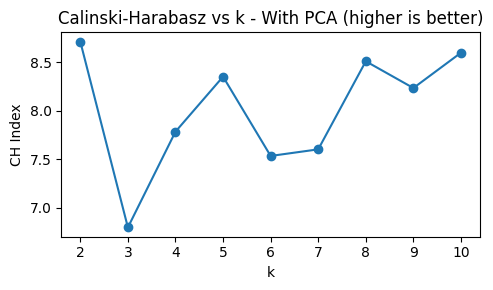

In [18]:
pca_full = PCA(svd_solver="full").fit(Xs)
cumvar = np.cumsum(pca_full.explained_variance_ratio_)
n_comp = int(np.searchsorted(cumvar, 0.95) + 1)

plt.figure(figsize=(5,3))
plt.plot(range(1, len(cumvar)+1), cumvar, marker="o")
plt.axhline(0.95, linestyle="--")
plt.title("PCA Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Ratio")
plt.tight_layout()
plt.show()

pca = PCA(n_components=n_comp, svd_solver="full")
Xp = pca.fit_transform(Xs)

print("Original features:", Xs.shape[1])
print("PCA components kept:", Xp.shape[1])
print("Explained variance per component:", pca.explained_variance_ratio_)
print("Cumulative variance:", cumvar)


ks = list(range(2, 11))
inertias_pca = []
sil_scores_pca = []
db_scores_pca = []
ch_scores_pca = []

for k in ks:
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels = km.fit_predict(Xp)
    inertias_pca.append(km.inertia_)
    sil_scores_pca.append(silhouette_score(Xp, labels))
    db_scores_pca.append(davies_bouldin_score(Xp, labels))
    ch_scores_pca.append(calinski_harabasz_score(Xp, labels))

plt.figure(figsize=(5,3))
plt.plot(ks, inertias_pca, marker="o")
plt.title("Elbow Plot (Inertia) - With PCA")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(ks, sil_scores_pca, marker="o")
plt.title("Silhouette vs k - With PCA")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(ks, db_scores_pca, marker="o")
plt.title("Davies-Bouldin vs k - With PCA (lower is better)")
plt.xlabel("k")
plt.ylabel("DB Index")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(ks, ch_scores_pca, marker="o")
plt.title("Calinski-Harabasz vs k - With PCA (higher is better)")
plt.xlabel("k")
plt.ylabel("CH Index")
plt.tight_layout()
plt.show()

In [21]:
best_k_pca=5
km_pca = KMeans(n_clusters=best_k_pca, n_init="auto", random_state=42)
labels_pca = km_pca.fit_predict(Xp)

daily_pca = daily.copy()
daily_pca["cluster"] = labels_pca

summary_pca = daily_pca.groupby("cluster").agg(
    days=("cluster", "size"),
    energy_Wh=("active_energy_Wh_sum", "mean"),
    intensity_max=("intensity_max", "mean"),
    voltage_mean=("voltage_mean", "mean"),
    sub1_ratio=("sub1_ratio", "mean"),
    sub2_ratio=("sub2_ratio", "mean"),
    sub3_ratio=("sub3_ratio", "mean"),
    other_ratio=("other_ratio", "mean"),
).sort_index()

print({"pca_components": n_comp, "n_clusters": 6})
summary_pca.round(2)


{'pca_components': 7, 'n_clusters': 6}


,days,energy_Wh,intensity_max,voltage_mean,sub1_ratio,sub2_ratio,sub3_ratio,other_ratio
cluster,,,,,,,,
0,9,56111.78,29.60,240.37,0.03,0.06,0.20,0.71
1,10,26139.87,23.72,241.38,0.02,0.02,0.29,0.68
2,1,20152.93,33.20,236.24,0.00,0.03,0.24,0.73
3,13,36861.83,32.12,241.34,0.05,0.12,0.32,0.51
4,2,49416.12,34.40,241.34,0.15,0.05,0.17,0.63


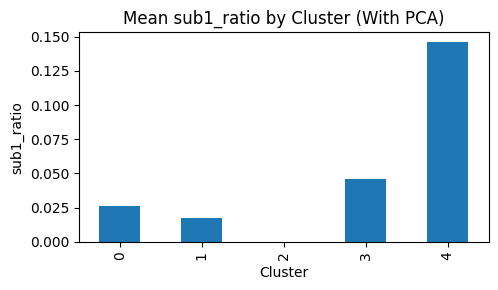

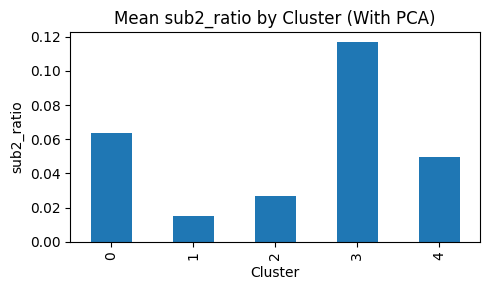

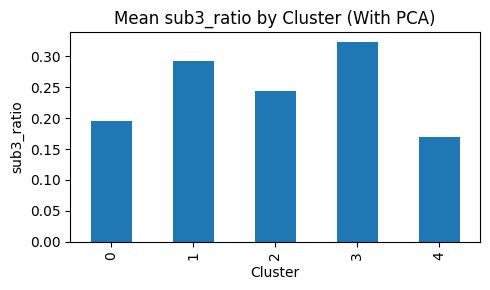

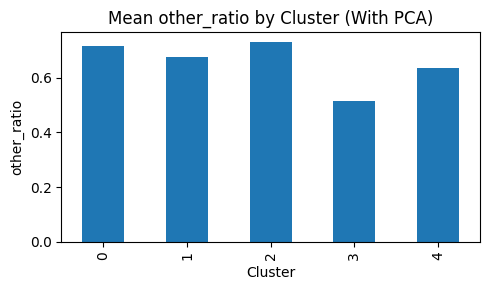

In [ ]:
ratio_cols = ["sub1_ratio", "sub2_ratio", "sub3_ratio", "other_ratio"]
means_pca = daily_pca.groupby("cluster")[ratio_cols].mean()

for col in ratio_cols:
    plt.figure(figsize=(5,3))
    means_pca[col].plot(kind="bar")
    plt.title(f"Mean {col} by Cluster (With PCA)")
    plt.xlabel("Cluster")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()



## 7. Evaluation & Comparison

We compare the selected `k` for both pipelines using multiple indices: **Silhouette**, **Davies–Bouldin**, and **Calinski–Harabasz**.


In [ ]:
def evaluate_pipeline(X_embedded: np.ndarray, labels: np.ndarray) -> dict[str, float]:
    return {
        "silhouette": float(silhouette_score(X_embedded, labels)),
        "davies_bouldin": float(davies_bouldin_score(X_embedded, labels)),
        "calinski_harabasz": float(calinski_harabasz_score(X_embedded, labels)),
    }

metrics_no_pca = evaluate_pipeline(Xs, labels_no_pca)
metrics_pca = evaluate_pipeline(Xp, labels_pca)

print("Best k (No PCA):", best_k_no_pca, metrics_no_pca)
print("Best k (With PCA):", best_k_pca, metrics_pca)

comparison = pd.DataFrame([metrics_no_pca, metrics_pca], index=["No PCA", "With PCA"])
comparison


Best k (No PCA): 5 {'silhouette': 0.17373360298679802, 'davies_bouldin': 1.1175425871294675, 'calinski_harabasz': 7.566986438979994}
Best k (With PCA): 5 {'silhouette': 0.1971461247179795, 'davies_bouldin': 1.0550953898301578, 'calinski_harabasz': 8.351183089595626}


,silhouette,davies_bouldin,calinski_harabasz
No PCA,0.173734,1.117543,7.566986
With PCA,0.197146,1.055095,8.351183



## 8. Discussion (Pros/Cons & Improvements)

**Pros of Dimensionality Reduction (PCA):**
- Removes noise and correlated redundancy, often improving cluster separation.
- Speeds up clustering on large feature sets.
- Helps avoid distance concentration issues in high dimensions.

**Cons:**
- Components are linear combinations, harder to interpret than raw features.
- If the structure is strongly non-linear, PCA may flatten useful curvature.
- If most variance is already in a few features, PCA may add little benefit.

**What can be improved:**
- Try **UMAP** or **t-SNE** for non-linear embeddings (primarily for visualization).  
- Use **HDBSCAN** or **Gaussian Mixture Models** to capture non-spherical clusters.  
- Incorporate **seasonality** and **weekday/weekend** indicators into features.  
- Evaluate **cluster stability** via bootstrapping and adjusted Rand index.  
- Validate clusters against downstream tasks (e.g., forecasting error reduction) or expert annotations.
